<a href="https://colab.research.google.com/github/vvjft/DL_BIQA/blob/main/CNN%2B%2BIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import scipy
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive') # LIVE
!cp -r /content/drive/MyDrive/magisterka/LIVEIQA_release2 /content
os.rename('/content/LIVEIQA_release2', '/content/LIVE')
drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
from scipy.signal import convolve2d
def normalize_and_slice(db_dir, train_data, val_data, test_data, patch_size=32, cross=False):

  def local_normalize(patch, P=3, Q=3, C=1):
      kernel = np.ones((P, Q)) / (P * Q)
      patch_mean = convolve2d(patch, kernel, boundary='symm', mode='same')
      patch_sm = convolve2d(np.square(patch), kernel, boundary='symm', mode='same')
      patch_std = np.sqrt(np.maximum(patch_sm - np.square(patch_mean), 0)) + C
      patch_ln = (patch - patch_mean) / patch_std
      return patch_ln.astype('float32')

  sets = {'train': [train_data, 'training'], 'val':[val_data, 'validation'], 'test':[test_data, 'test']}

  for key, (data, name) in sets.items():

    output_dir_full = f'{db_dir}/normalized_distorted_images/{name}/full/' # where to store normalized distorted images
    output_dir_patches = f'{db_dir}/normalized_distorted_images/{name}/patches/' # where to store patches
    norm_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/norm_{name}.csv'
    patch_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/patch_{name}.csv'
    os.makedirs(output_dir_full, exist_ok=True)
    os.makedirs(output_dir_patches, exist_ok=True)

    norm_info_list = []
    patch_info_list = []

    for index, row in data.iterrows():
        image_filename = row[0]
        mos_value = row[1]
        distortion = row[2]
        image_path = f'{db_dir}/distorted_images/{image_filename}'
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_filename}")
            continue

        # Normalize the image
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_normalized = local_normalize(image_gray)
        # Save
        image_filename = f'NORM_{image_filename}'
        norm_info_list.append([image_filename, mos_value, distortion])
        cv2.imwrite(output_dir_full+image_filename, image_normalized)
        # Slice to patches
        height, width = image_normalized.shape[:2]
        num_patches_y = height // patch_size
        num_patches_x = width // patch_size
        patch_count = 0
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                patch = image_normalized[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                patch_path = os.path.join(output_dir_patches, f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp")
                patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp"
                cv2.imwrite(patch_path, patch)
                # Add patch info to the list
                patch_info_list.append([patch_filename, mos_value, distortion])
                patch_count += 1

    norm_info_df = pd.DataFrame(norm_info_list, columns=['image_filename', score_measure, 'Distortion'])
    norm_info_df.to_csv(norm_file_info_path, index=False)
    print(f"[{name}]: Saved full normalized distorted image info to:\n{patch_file_info_path}.")
    patch_info_df = pd.DataFrame(patch_info_list, columns=['image_filename', score_measure, 'Distortion'])
    patch_info_df.to_csv(patch_file_info_path, index=False)
    print(f"[{name}]: Saved patch info to {patch_file_info_path}.")

In [4]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def load_live(base_dir, filter=False):
    data_path = os.path.join(base_dir, 'dmos_with_names.csv')
    data = pd.read_csv(data_path, index_col=False)
    if filter:
      distortion_types = [1, 2, 3, 4] # filter distortions: jp2k, jpeg, wn and blur
      data = data[data['image_filename'].apply(lambda x: int(x.split('_')[1]) in distortion_types)]
    return data

def split_data(data1, data2=None, params=None, cross=False):
    train_data, test_data = train_test_split(data1, test_size=0.2, random_state=40)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=40)
    return train_data, val_data, test_data

live_dir = 'LIVE'
db_dir = live_dir
score_measure = 'DMOS'

data_live = load_live(live_dir, filter=False)
data_live.to_csv('LIVE/dmos_with_names.csv', index=False)
data = data_live

train_data, val_data, test_data = split_data(data)
normalize_and_slice(db_dir, train_data, val_data, test_data)

train_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/training/patch_training.csv')
val_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/validation/patch_validation.csv')
test_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/test/patch_test.csv')

[training]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/training/patch_training.csv.
[training]: Saved patch info to LIVE/normalized_distorted_images/training/patch_training.csv.
[validation]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/validation/patch_validation.csv.
[validation]: Saved patch info to LIVE/normalized_distorted_images/validation/patch_validation.csv.
[test]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/test/patch_test.csv.
[test]: Saved patch info to LIVE/normalized_distorted_images/test/patch_test.csv.


In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Function to create a single column with one-hot encoded numpy arrays with integer values
def encode_distortion(dataframes):
    for i in range(len(dataframes)):
        my_dists = dataframes[i]['Distortion']
        le = LabelEncoder()
        y_class_encoded = le.fit_transform(my_dists)
        my_dists_one_hot = to_categorical(y_class_encoded, num_classes=5).astype(int)
        # Assign to a new column as numpy arrays
        dataframes[i]['Distortion_encoded'] = [np.array(one_hot) for one_hot in my_dists_one_hot]
        dataframes[i] = dataframes[i].drop(['Distortion'], axis=1)
    return dataframes

train_data, val_data, test_data = encode_distortion([train_data, val_data, test_data])

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(base_dir, train_data, val_data, test_data, batch_size):
    datagen = ImageDataGenerator()
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=os.path.join(base_dir, 'training/patches/'),
        x_col='image_filename',
        y_col=['DMOS', 'Distortion_encoded'],
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='multi_output',
        shuffle=True,
        seed=42
    )
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=os.path.join(base_dir, 'validation/patches/'),
        x_col='image_filename',
        y_col=['DMOS', 'Distortion_encoded'],
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='multi_output',
        shuffle=True,
        seed=42
    )
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        directory=os.path.join(base_dir, 'test/patches/'),
        x_col='image_filename',
        y_col=['DMOS', 'Distortion_encoded'],
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='multi_output',
        shuffle=False,
        seed=42
    )
    return train_generator, val_generator, test_generator

# Define file paths
base_dir = 'LIVE/normalized_distorted_images'
# Create generators
train_generator, val_generator, test_generator = create_data_generators(base_dir, train_data, val_data, test_data, batch_size=32)


Found 161332 validated image filenames.
Found 53196 validated image filenames.
Found 53332 validated image filenames.


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Dropout, Input, Flatten

# Define the model
input_shape = (32, 32, 3)

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(512, activation='relu')(x)

dmos_output = tf.keras.layers.Dense(1, name='dmos')(x)
distortion_output = tf.keras.layers.Dense(5, activation='softmax', name='distortion')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=[dmos_output, distortion_output])

model.compile(optimizer='adam',
              loss={'dmos': 'mae', 'distortion': 'categorical_crossentropy'},
              metrics={'dmos': 'mae', 'distortion': 'accuracy'})

In [8]:
history = model.fit(train_generator, epochs=40, validation_data=val_generator)

Epoch 1/40
5042/5042 [==============================] - 110s 22ms/step - loss: 13.4369 - dmos_loss: 12.6637 - distortion_loss: 0.7732 - dmos_mae: 12.6637 - distortion_accuracy: 0.6659 - val_loss: 12.4465 - val_dmos_loss: 11.6266 - val_distortion_loss: 0.8200 - val_dmos_mae: 11.6266 - val_distortion_accuracy: 0.6478
Epoch 2/40
5042/5042 [==============================] - 108s 21ms/step - loss: 10.4486 - dmos_loss: 9.8776 - distortion_loss: 0.5710 - dmos_mae: 9.8776 - distortion_accuracy: 0.7501 - val_loss: 11.9567 - val_dmos_loss: 11.2979 - val_distortion_loss: 0.6589 - val_dmos_mae: 11.2979 - val_distortion_accuracy: 0.7096
Epoch 3/40
5042/5042 [==============================] - 106s 21ms/step - loss: 9.8021 - dmos_loss: 9.2825 - distortion_loss: 0.5195 - dmos_mae: 9.2825 - distortion_accuracy: 0.7698 - val_loss: 11.5744 - val_dmos_loss: 10.9122 - val_distortion_loss: 0.6622 - val_dmos_mae: 10.9122 - val_distortion_accuracy: 0.7150
Epoch 4/40
5042/5042 [==============================] 

In [9]:
test_generator.reset()
predictions = model.predict(test_generator)
dmos_predictions = predictions[0]
distortion_predictions = np.argmax(predictions[1], axis=1)
patch_info = test_generator.filenames # get list of test patches
image_scores = {}
image_distortions = {}
for i, patch_path in enumerate(patch_info):
    # Extract the base image name by removing the patch-specific part
    base_image_name = "_".join(patch_path.split('_')[0:-2]) + '.bmp'
    if base_image_name not in image_scores:
        image_scores[base_image_name] = []
        image_distortions[base_image_name] = []
    image_scores[base_image_name].append(dmos_predictions[i])
    image_distortions[base_image_name].append(distortion_predictions[i])


average_scores = {image: np.mean(scores) for image, scores in image_scores.items()}
predicted_distortions = {image: np.bincount(distortions).argmax() for image, distortions in image_distortions.items()}

average_scores_df = pd.DataFrame({
    'Image': list(average_scores.keys()),
    f'Predicted_{score_measure}': list(average_scores.values()),
    'Predicted_Distortion': list(predicted_distortions.values())
})
#print("Summary of test predictions:")
#print(average_scores_df.describe())

test_images_score = pd.read_csv(f'{db_dir}/normalized_distorted_images/test/norm_test.csv')
test_images_score.rename(columns={'image_filename':'Image', score_measure:score_measure, 'Distortion':'Distortion'}, inplace=True)

# Force all extensions to be '.bmp' (there are inconsitencies between mos_with_names.txt and actual filename: '.bmp' vs '.BMP')
test_images_score['Image'] = test_images_score['Image'].apply(lambda x: x.lower())
average_scores_df['Image'] = average_scores_df['Image'].apply(lambda x: x.lower())

# Merge dataframes to match predicted mos with ground-truth score
merged_df = average_scores_df.merge(test_images_score, on="Image", how="inner")
merged_df.rename(columns={f'Predicted_{score_measure}_x': f'Predicted_{score_measure}', f'Predicted_{score_measure}_y': {score_measure}}, inplace=True)
merged_df['Image'] = merged_df['Image'].str.replace('norm_', '')

distortion_mapping = {0: 'fastfading', 1: 'gblur', 2: 'jp2k', 3: 'jpeg', 4: 'wn'}
merged_df['Predicted_Distortion'] = merged_df['Predicted_Distortion'].map(distortion_mapping)
merged_df = merged_df[['Image', f'Predicted_{score_measure}', score_measure, 'Predicted_Distortion', 'Distortion']]

print(merged_df)

1667/1667 [==============================] - 23s 14ms/step
                        Image  Predicted_DMOS       DMOS Predicted_Distortion  \
0         lighthouse2_4_5.bmp       20.523899  24.912864                gblur   
1               plane_5_1.bmp       46.689453  49.804950           fastfading   
2               house_3_2.bmp       17.478750  20.527485                   wn   
3             cemetry_2_4.bmp       18.491508  24.492693                 jpeg   
4             cemetry_1_1.bmp       63.374439  73.091742                 jp2k   
..                        ...             ...        ...                  ...   
151          sailing2_3_2.bmp       17.144535  21.610529                   wn   
152           parrots_4_1.bmp       32.285904  23.747801                gblur   
153             house_3_1.bmp       65.529060  66.531650                   wn   
154          womanhat_3_2.bmp       19.315363  23.038582                   wn   
155  studentsculpture_5_1.bmp       78.802162  84.

All:
  LCC (Linear Correlation Coefficient): 0.9494866185374411
  SROCC (Spearman Rank Order Correlation Coefficient): 0.9536461835964032
Distortion: fastfading
  LCC: 0.8977960998548532
  SROCC: 0.9110122358175751
Distortion: gblur
  LCC: 0.9476322321970797
  SROCC: 0.95615763546798
Distortion: jp2k
  LCC: 0.9299244642369537
  SROCC: 0.9585777126099707
Distortion: jpeg
  LCC: 0.9891004114329854
  SROCC: 0.9708498790793574
Distortion: wn
  LCC: 0.9911398129875467
  SROCC: 0.9829302987197722


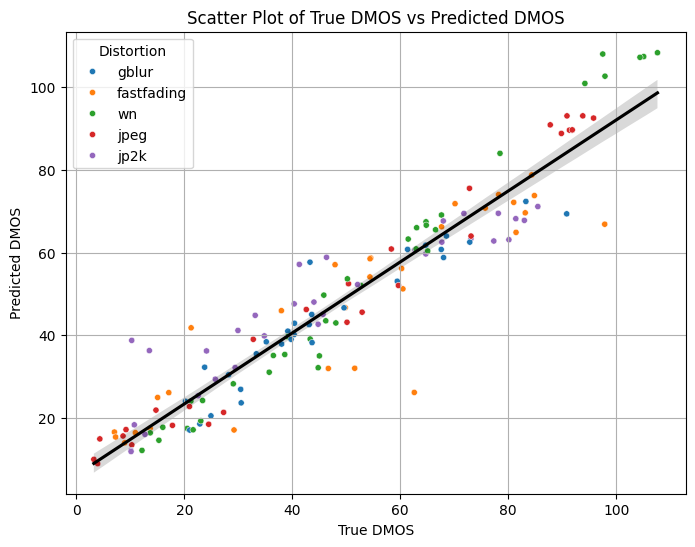

In [12]:
from scipy.stats import spearmanr, pearsonr

cleaned_df = merged_df.dropna()
cleaned_df = cleaned_df[np.isfinite(cleaned_df[score_measure]) & np.isfinite(cleaned_df[f'Predicted_{score_measure}'])]


lcc = pearsonr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]
srocc = spearmanr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]

print('All:')
print(f"  LCC (Linear Correlation Coefficient): {lcc}")
print(f"  SROCC (Spearman Rank Order Correlation Coefficient): {srocc}")

# Calculate LCC and SROCC for each distortion
grouped = cleaned_df.groupby('Distortion')

for name, group in grouped:
    group_lcc = pearsonr(group[f'Predicted_{score_measure}'], group[score_measure])[0]
    group_srocc = spearmanr(group[f'Predicted_{score_measure}'], group[score_measure])[0]
    print(f"Distortion: {name}")
    print(f"  LCC: {group_lcc}")
    print(f"  SROCC: {group_srocc}")

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=score_measure, y=f'Predicted_{score_measure}', data=merged_df, hue='Distortion', palette='tab10', s=20)
sns.regplot(x=score_measure, y=f'Predicted_{score_measure}', data=merged_df, scatter=False, line_kws={'color': 'black'})
plt.xlabel(f'True {score_measure}')
plt.ylabel(f'Predicted {score_measure}')
plt.title(f'Scatter Plot of True {score_measure} vs Predicted {score_measure}')
plt.grid(True)
plt.show()

#y_pred = dmos_predictions
#y_true = test_generator.labels
# Training progress (loss minimization)
#plt.figure(figsize=(10, 5))
#plt.plot(history.history['loss'], label='Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.title('Model Loss')
#plt.show()

Classification Report:
               precision    recall  f1-score   support

  fastfading       0.64      0.97      0.77        30
       gblur       1.00      0.86      0.93        29
        jp2k       0.95      0.59      0.73        32
        jpeg       1.00      1.00      1.00        28
          wn       0.97      1.00      0.99        37

    accuracy                           0.88       156
   macro avg       0.91      0.88      0.88       156
weighted avg       0.92      0.88      0.88       156



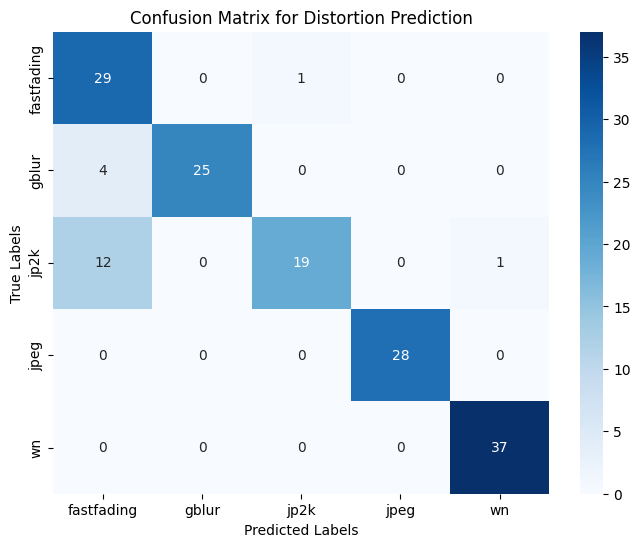

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification report and confusion matrix for distortion predictions
true_distortion = merged_df['Distortion']
predicted_distortion = merged_df['Predicted_Distortion']

# Classification report
class_names = ['fastfading', 'gblur', 'jp2k', 'jpeg', 'wn']
report = classification_report(true_distortion, predicted_distortion, target_names=class_names)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_distortion, predicted_distortion)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Distortion Prediction')
plt.show()